<h1><center>COVID-19 twitter data analysis</center><h1>

## 0. Required Libraries:

In [3]:
# we are importing required python libraries for this whole project

from zipfile import ZipFile
import pandas as pd
import numpy as np
from itertools import groupby
import re
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

## 1. Reading data:

In [2]:
# unzipping and extracting the source data files:

with ZipFile('/content/drive/My Drive/covid_19/dataset.zip', 'r') as zf:
    zf.extractall('/content/data/')


In [10]:
data = pd.read_csv("/content/data/covid19_tweets.csv")
data.shape

(179108, 13)

In [11]:
# How our data looks like?
data.head(5)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [12]:
# since all our columns are in object fromat data type, so for ease of operations we are converting it into proper date data type:
data['date'] = pd.to_datetime(data.date)

## 2. Simple analysis:

##### Collected data from date to till?

In [7]:
print("Data collected from {0} to {1}".format(min(data.date),max(data.date)))

Data collected from 2020-07-24 23:47:08 to 2020-08-30 09:07:39


##### From how many accounts we collected this data?

In [5]:
print("We have tweets from {} accounts".format(len(data['user_name'].unique())))

We have tweets from 92276 accounts


##### how many new accounts were created with in the Augest month?

In [ ]:
print("No.of new accounts created from July 24'th to Aug 30'th are: ",data[data.user_created.dt.month.between(7, 8)]['user_name'].nunique())

No.of new accounts created from July 24'th to Aug 30'th are:  17375


##### Most of the tweets are getting from which accounts?

In [8]:
print("The top 10 accounts that are accountable for most no.of tweets in the given data are: ",data['user_name'].value_counts()[0:10])

The top 10 accounts that are accountable for most no.of tweets in the given data are:  GlobalPandemic.NET        679
Coronavirus Updates       625
covidnews.ch              402
Open Letters              390
Blood Donors India        282
Hindustan Times           280
IAM Platform              266
Paperbirds_Coronavirus    259
IANS Tweets               244
ANI                       233
Name: user_name, dtype: int64


##### What are the most used hashtags?

- Each tweet consists multiple hash tags so we need preprocess hash tags column

In [100]:
hashtags = data['hashtags'].tolist()

In [103]:
cleaned_hashtags = []
new_data = dict()
for j in hashtags:
  if type(j) == str:
    sub_list = j.split(',')
    for ele in sub_list:
      cleaned_hashtags.append((re.sub('[^A-Za-z0-9]+', ' ', ele)).lower().strip())
for key, group in groupby(cleaned_hashtags):
  if key in new_data:
    new_data[key] = new_data[key]+len(list(group))
  else:
    new_data[key] = len(list(group)) 

new_data = pd.DataFrame(new_data.items(),columns=['Hashtag', 'count'])
new_data = new_data.sort_values('count',ascending=False)


In [108]:
print("The top 10 hash tags are: ") 
new_data.head(10)

The top 10 hash tags are: 


,Hashtag,count
0,covid19,100312
2,coronavirus,10197
188,pandemic,1625
78,covid 19,1470
88,covid,1299
244,india,1193
413,corona,1162
164,trump,1101
341,lockdown,963
112,coronaviruspandemic,882


##### What are the top 10 devices used?

In [125]:
data['source'].value_counts()[0:10]

Twitter Web App        56891
Twitter for Android    40179
Twitter for iPhone     35472
TweetDeck               8543
Hootsuite Inc.          7321
Twitter for iPad        4336
Buffer                  2728
Sprout Social           1833
Instagram               1759
IFTTT                   1545
Name: source, dtype: int64

<br>

## 3. Text Analysis:

### Text Cleaning:

In [13]:
# https://stackoverflow.com/a/47091490/4084039

# Here we are definig a function to clean our text to data. 

def text_cleaning(phrase):

    # twitter specific:

    phrase = re.sub("RT @[\w]*:","",phrase)                # removing 'RT' from the tweets. since most of the tweets having 'RT' in the starting.
    phrase = re.sub("@[\w]*","",phrase)
    phrase = re.sub("https?://[A-Za-z0-9./]*","",phrase)


    # specific
    phrase = re.sub(r"won't", "will not", phrase)           # expand all the shortcuts in the text. ex: won't=> will not
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub('\\r', ' ',phrase)
    phrase = re.sub('\\"', ' ',phrase)
    phrase = re.sub('\\n', ' ',phrase)
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)          # remove the unnessasary charcters other than digits, alphabets(small&captial)

    
    
    return phrase

In [14]:
data['text'] = data['text'].apply(lambda x: text_cleaning(x))

In [15]:
data['text'].head(10)

0    If I smelled the scent of hand sanitizers toda...
1    Hey and would not it have made more sense to h...
2     Trump never once claimed COVID19 was a hoax W...
3     The one gift COVID19 has give me is an apprec...
4    25 July Media Bulletin on Novel CoronaVirusUpd...
5     coronavirus covid19 deaths continue to rise I...
6    How COVID19 Will Change Work in General and re...
7    You now have to wear face coverings when out s...
8    Praying for good health and recovery of covid1...
9    POPE AS GOD Prophet Sadhu Sundar Selvaraj Watc...
Name: text, dtype: object

### Text polarity:

In [16]:
# To determine the the sentiment of the tweet we are using some predefined ibraries.
# what is sentiment? ex: 
                      #  The movie was very nice. (they responding in postive way, so the sentiment is positive.)
                      #  We just finished the movie (this is neutral sentense)
                      #  The movie does not reach our expectations. (their response is negative, so the sentiment is negative).

                      #  for any given sentense the sentiment lies between [-1,1]=> =0 neutral sentense, >0 positve sentense., <0 negative sentense.
                      

sid_obj = SentimentIntensityAnalyzer() 

for i, j in tqdm(enumerate(data['text'])): 

  sentiment_dict = sid_obj.polarity_scores(j) 

  data.loc[i,'Positive'] = sentiment_dict['pos']*100
  data.loc[i,'Negative'] = sentiment_dict['neg']*100
  data.loc[i,'Neutral']  = sentiment_dict['neu']*100

  if sentiment_dict['compound'] >= 0.05 : 
      data.loc[i,'over_all'] = 1
      
  elif sentiment_dict['compound'] <= - 0.05 : 
      data.loc[i,'over_all'] = -1
  
  else : 
      data.loc[i,'over_all'] = 0


179108it [15:24, 193.67it/s]


In [17]:
data.to_csv('/content/drive/My Drive/preprocessed_tweetdata.csv')  # we are storing this new information to our disk. since everytime it is very difficut to perfrom this operation.

In [4]:
data = pd.read_csv('/content/drive/My Drive/preprocessed_tweetdata.csv',index_col=0)

In [5]:
data['date'] = pd.to_datetime(data.date)

### Distribution of Positive, Negative and Neutral tweets:

<BarContainer object of 3 artists>

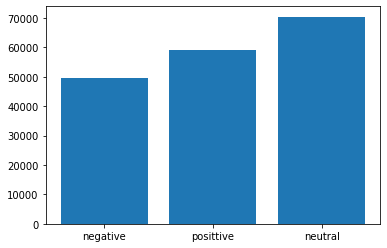

In [20]:
# We will see how the sentiments are distributed acorss the data / counting the no.of sentiments for each class.

plt.bar(['negative','posittive','neutral'],[data['over_all'].value_counts()[-1],data['over_all'].value_counts()[0],data['over_all'].value_counts()[1]])

### Frequent words/contents in Positive tweets:

 - Here we will see visually which words/contents that are repeating most in the positive tweets:

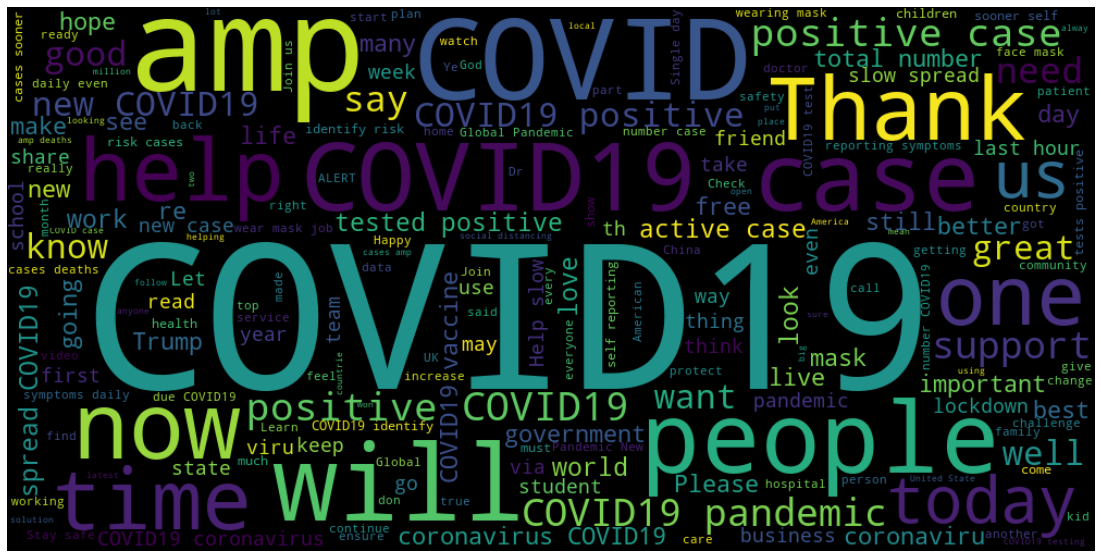

In [21]:
text=" "
text = " ".join(data[data.over_all==1]['text'])

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1000,height=500).generate(text)

# Display the generated image:
plt.figure(figsize=(25,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

###### If observe the above the diagram the most repeating words in the positve tweets are: 
 - COVID-19
 - time
 - people
 - Help
 - support
 - Thank
 - positive case
 - pandemic
 - lock down
 - business

###### we will see the above problem from another ponit of view:
- Here we will use IDF of words:
  - If 'IDF' of word is low means that, the word is occuring so many times in the corpus. (since IDF = log(D/n)  where D = total no.of documents, n = total no.of documents consists the word )

In [11]:
tf = TfidfVectorizer(use_idf=True,ngram_range=(1,3),min_df=10,stop_words='english')
tf.fit_transform(data[data.over_all==1]['text'].values)
idf = tf.idf_


In [12]:
word_array = np.array(tf.get_feature_names())

sorted_indexes = np.argsort(idf).flatten()

print("The top 20 rare words that are occuring in positive teets:", "\n".join(word_array[sorted_indexes[0:20]]))

The top 20 rare words that are occuring in positive teets: covid19
cases
amp
covid
positive
new
coronavirus
19
covid 19
help
people
pandemic
like
today
health
number
good
deaths
just
day


<br>

### Frequent words/contents in Negative tweets:

 - Here we will see visually which words/contents that are repeating most in the positive tweets:

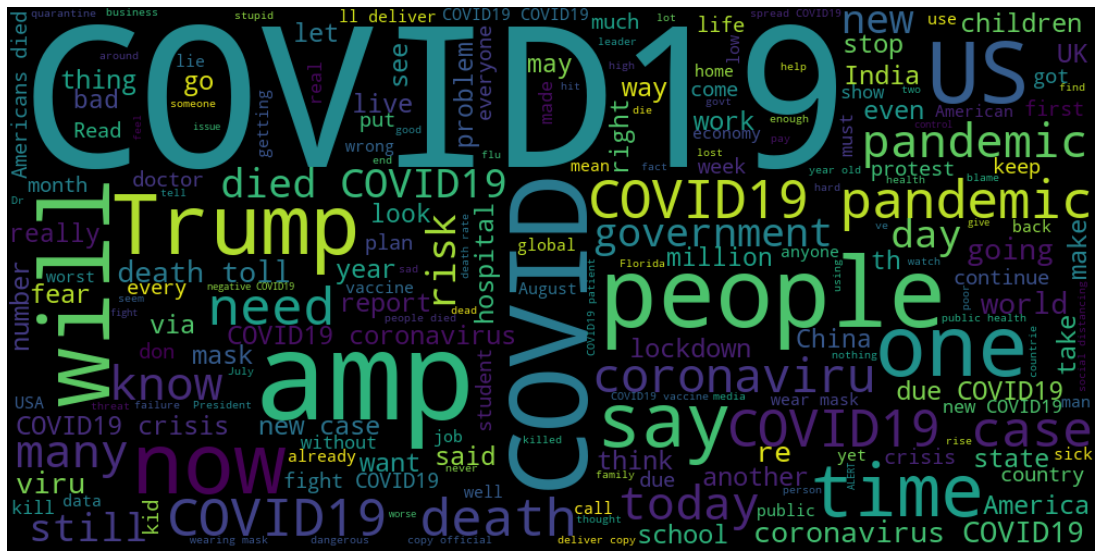

In [16]:
text=" "
text = " ".join(data[data.over_all==-1]['text'])

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1000,height=500).generate(text)

# Display the generated image:
plt.figure(figsize=(25,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

###### If observe the above the diagram the most repeating words in the positve tweets are: 
 - COVID-19
 - Trump 
 - death
 - died
 - americans died
 - kill
 - people
 - need
 - pandemic
 - risk

 - In negative tweets surprisingly 'Trump' name repeated so many times. May be because of his hilarious comments on vacccine,virus and also on H1b visa restrictions  

###### we will see the above problem from another ponit of view:
- Here we will use IDF of words:
  - If 'IDF' of word is low means that, the word is occuring so many times in the corpus. (since IDF = log(D/n)  where D = total no.of documents, n = total no.of documents consists the word )

In [17]:
tf = TfidfVectorizer(use_idf=True,ngram_range=(1,3),min_df=10,stop_words='english')
tf.fit_transform(data[data.over_all==-1]['text'].values)
idf = tf.idf_


In [18]:
word_array = np.array(tf.get_feature_names())

sorted_indexes = np.argsort(idf).flatten()

print("The top 20 rare words that are occuring in positive teets:", "\n".join(word_array[sorted_indexes[0:20]]))

The top 20 rare words that are occuring in positive teets: covid19
covid
people
coronavirus
amp
19
covid 19
new
pandemic
cases
death
trump
just
deaths
died
crisis
health
000
virus
risk


<br>

### How sentiments are changing over period of time?

 - since we have sentiment score for each tweet, so we can do one thing from this. We will caluculate the median value of postive sentense sentiments and the median value of negative sentense sentiments in a day. 
 - So that we can understand how this two are changing over period of time.
 - why median why not mean? since mean can change with one extreme value but on the other hand median will not affect the central value.

In [ ]:
positive_data = data.loc[data['over_all'] == 1]
negative_data = data.loc[data['over_all'] ==-1]

In [ ]:
positivity_over_period = positive_data.groupby(positive_data['date'].dt.date)[['Positive']].median()
negativity_over_period = negative_data.groupby(negative_data['date'].dt.date)[['Negative']].median()
no_of_tweets_per_day   = data.groupby(data['date'].dt.date)[['text']].count()
no_of_tweets_per_day.reset_index(level=0, inplace=True)

In [ ]:
result = pd.merge(positivity_over_period, negativity_over_period, left_on='date', right_on='date')

result.reset_index(level=0, inplace=True)

result.head()


,date,Positive,Negative
0,2020-07-24,21.1,19.1
1,2020-07-25,18.8,18.4
2,2020-07-26,18.4,18.8
3,2020-07-27,18.5,18.4
4,2020-07-28,18.7,18.7


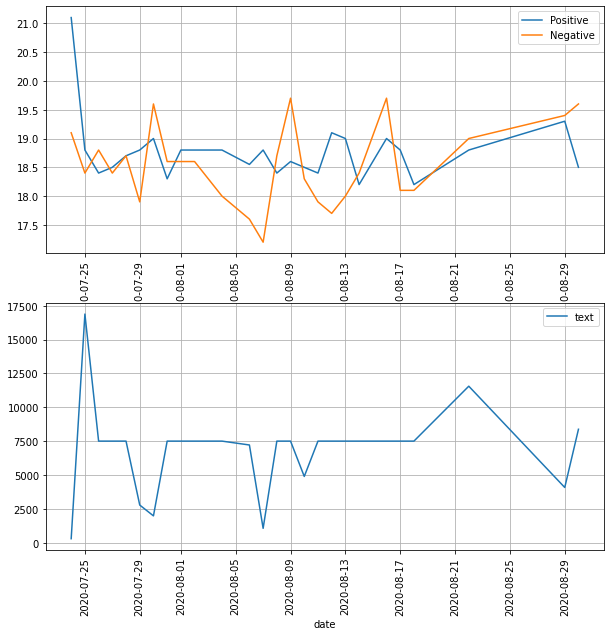

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1)

result.set_index('date').plot(figsize=(10,10), grid=True,rot=90,ax=axes[0])

no_of_tweets_per_day.set_index('date').plot(figsize=(10,10), grid=True,rot=90,ax=axes[1])

 - If we observe the above graph the postive and negative sentiments are almost constant over a period of august.
 

#### what happens on 2020-08-07?

- One interesting thing that I observed from the graph is that the no.of tweets and the negative sentiment are suddenly redunced on Aug-9th.
- The reason may be on that day "kozhikode plane crash" incident happened. So because of that incident may be no.of tweets reduced regarding covid-19.

<br>

### Follwers count over a period of time analysis:

In [ ]:
# taking top-5 accounts which accountable for most tweets:

data['user_name'].value_counts()[0:5]

GlobalPandemic.NET     679
Coronavirus Updates    625
covidnews.ch           402
Open Letters           390
Blood Donors India     282
Name: user_name, dtype: int64

 - So the above users are the most tweeted people in the month of the august. So now let's analyse their follwers count and their tweets sentiment over the time

#### Follwers count analysis over period of time for above 5 profiles:

In [ ]:
def followers_analysis(user_name,data):
  user_data = data.loc[data['user_name'] == user_name]

  user_positive_data = user_data.loc[user_data['over_all'] == 1]
  user_negative_data = user_data.loc[user_data['over_all'] ==-1]

  user_positivity_over_period = user_positive_data.groupby(user_positive_data['date'].dt.date)[['Positive']].median()
  user_negativity_over_period = user_negative_data.groupby(user_negative_data['date'].dt.date)[['Negative']].median()
  sentiments = pd.merge(user_positivity_over_period, user_negativity_over_period, left_on='date', right_on='date')
  sentiments.reset_index(level=0, inplace=True)


  no_of_follwers_per_day   = user_data.groupby(user_data['date'].dt.date)[['user_followers']].mean()
  no_of_follwers_per_day.reset_index(level=0, inplace=True)

  no_of_tweets_per_day   = user_data.groupby(user_data['date'].dt.date)[['text']].count()
  no_of_tweets_per_day.reset_index(level=0, inplace=True)
  no_of_tweets_per_day.columns=['date','no_of_tweets']


  fig, axes = plt.subplots(nrows=3, ncols=1)

  sentiments.set_index('date').plot(figsize=(10,10), grid=True,rot=90,ax=axes[0])
  no_of_follwers_per_day.set_index('date').plot(figsize=(10,10), grid=True,rot=90,ax=axes[1])
  no_of_tweets_per_day.set_index('date').plot(figsize=(10,10), grid=True,rot=90,ax=axes[2])



##### For 'Coronavirus Updates':

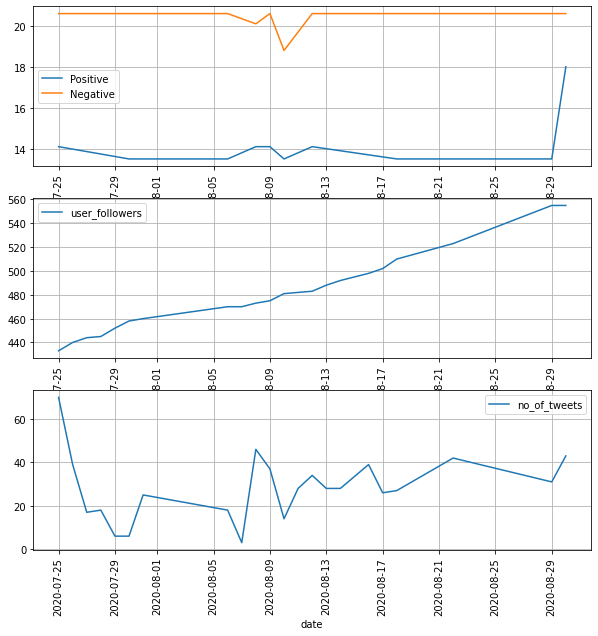

In [ ]:
followers_analysis('Coronavirus Updates',data)

 - No.of follwers  for the user "Coronavirus Updates" were increased rapidly.

##### For 'Blood Donors India':

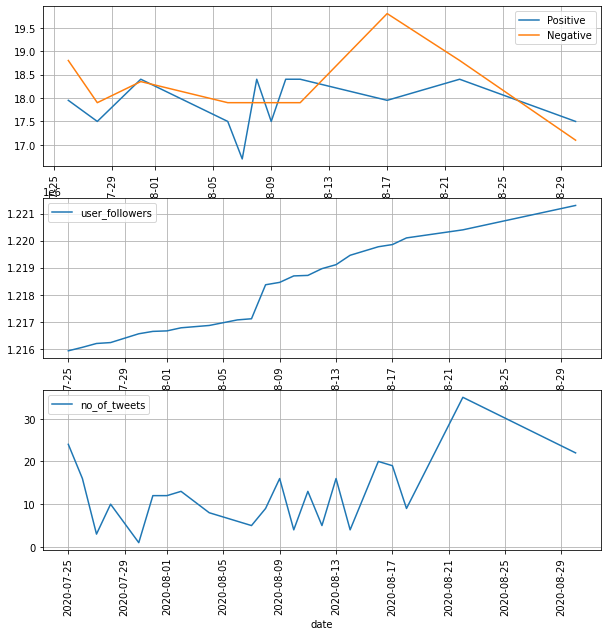

In [ ]:
followers_analysis('Blood Donors India',data)

##### For GlobalPandemic.NET:

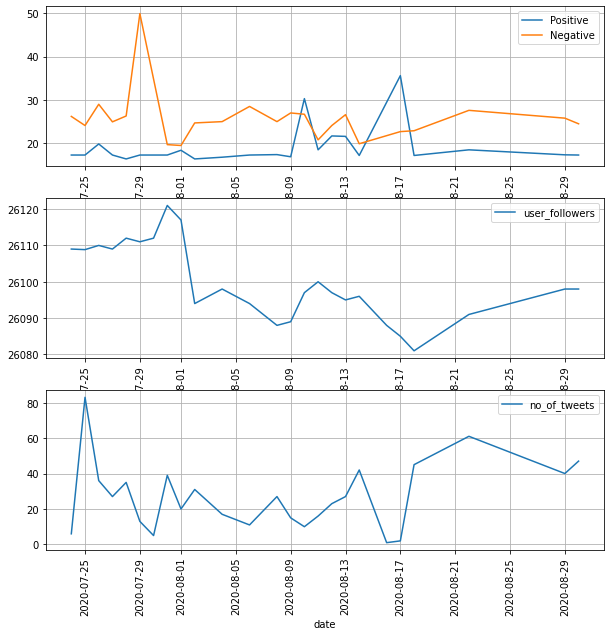

In [ ]:
followers_analysis('GlobalPandemic.NET',data)

<br>

<br>

## Summary:

- This is not end of this case study., we can do some more analysis from the location point of view.
  - But since our location data was not properly prepared. What I mean by that is suppose if I want perform analysis on coutrywise, that is not possible on this raw data.
  - We need to roll them up ex: Mumbai, Hyderabad, Delhi, etc etc---> "India". We need to convert all this individual locations to single location.
  - For that we can use 'Geopy' API., But in the free edition we can make only 1000 calls to the api. 

